## 1. Setup

### 1.1 Install dependencies

In [273]:
#!pip install -U -q torch torchvision matplotlib tqdm gdown

### 1.2 Check if GPU available

In [1]:
import torch

print(torch.cuda.is_available())

True


## 2. Load data 

Meta data are stored in a json file. Read the Json file and check entries of the first two samples.

In [37]:
import json

json_file_path = 'Dataset/dataset_label.json'

with open(json_file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

Much of the training was conducted on a representative subset of the data set using the algorithm below for easier handleability.

In [38]:
## Due to HUGE size of data set, I will build a dataset on top (of smaller size)
## New data set should be representative of the original data set

## Define count limits per split
# count_limits = {"val": 50, "train": 200, "test": 80}

## Initialize counters for each split and landcover_id
#count_per_split_landcover = {split: {} for split in count_limits}

# Initialize filtered data
#filtered_data = []

# Iterate over unique landcover_ids
#unique_landcover_ids = set(entry["landcover_ids"] for entry in data)
#for landcover_id in unique_landcover_ids:
#    # Iterate over splits
#    for split in count_limits:
#        # Iterate over entries in the data
#        for entry in data:
#            # Check if the entry matches the current landcover_id and split
#            if entry["landcover_ids"] == landcover_id and entry["split"] == split:
#                # Check if the count limit is not reached for the split and landcover_id
#                if count_per_split_landcover[split].get(landcover_id, 0) < count_limits[split]:
#                    # Include the entry
#                    filtered_data.append(entry)
#                    # Update the counter
#                    count_per_split_landcover[split][landcover_id] = count_per_split_landcover[split].get(landcover_id, 0) + 1
#
#data = filtered_data

### 2.1 Inspect meta data

#### 2.1.1 Inspect single labels

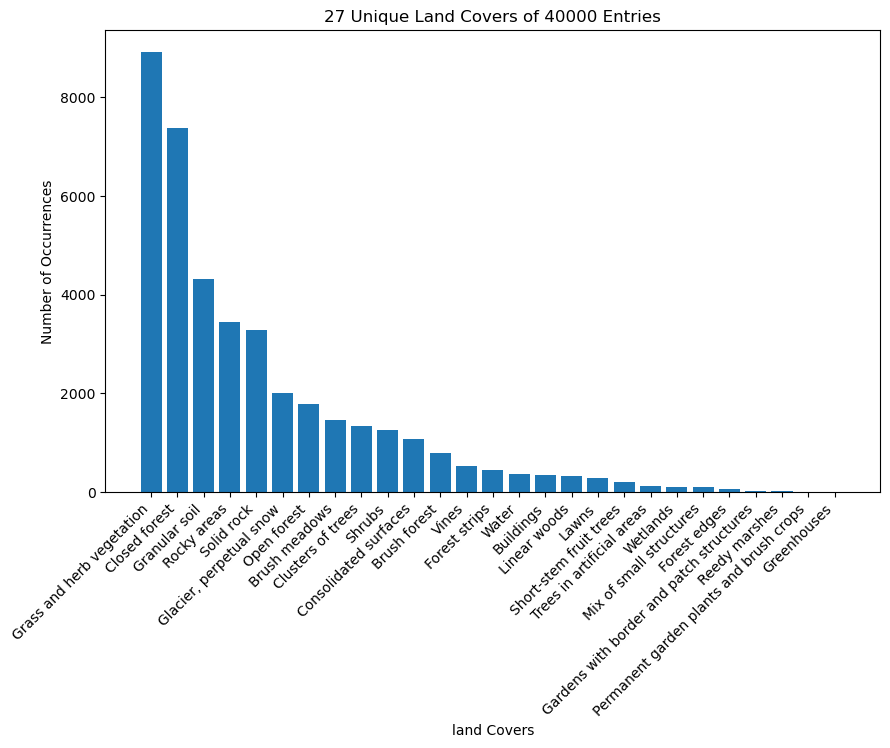

In [39]:
import matplotlib.pyplot as plt
from collections import Counter

landcover_texts = [entry["landcover_text"] for entry in data]# if entry.get("split") == "val"])

entry_counts = Counter(landcover_texts)
entry_counts_sorted = sorted_counts = dict(sorted(entry_counts.items(), key=lambda item: item[1], reverse=True))


plt.figure(figsize=(10, 6))
plt.bar(list(entry_counts_sorted.keys()), list(entry_counts_sorted.values()))
plt.xticks(rotation=45, ha='right')
plt.xlabel('land Covers')
plt.ylabel('Number of Occurrences')
plt.title(f"{len(entry_counts)} Unique Land Covers of {len(data)} Entries")
plt.show()

Plot a sample image for each single class label:

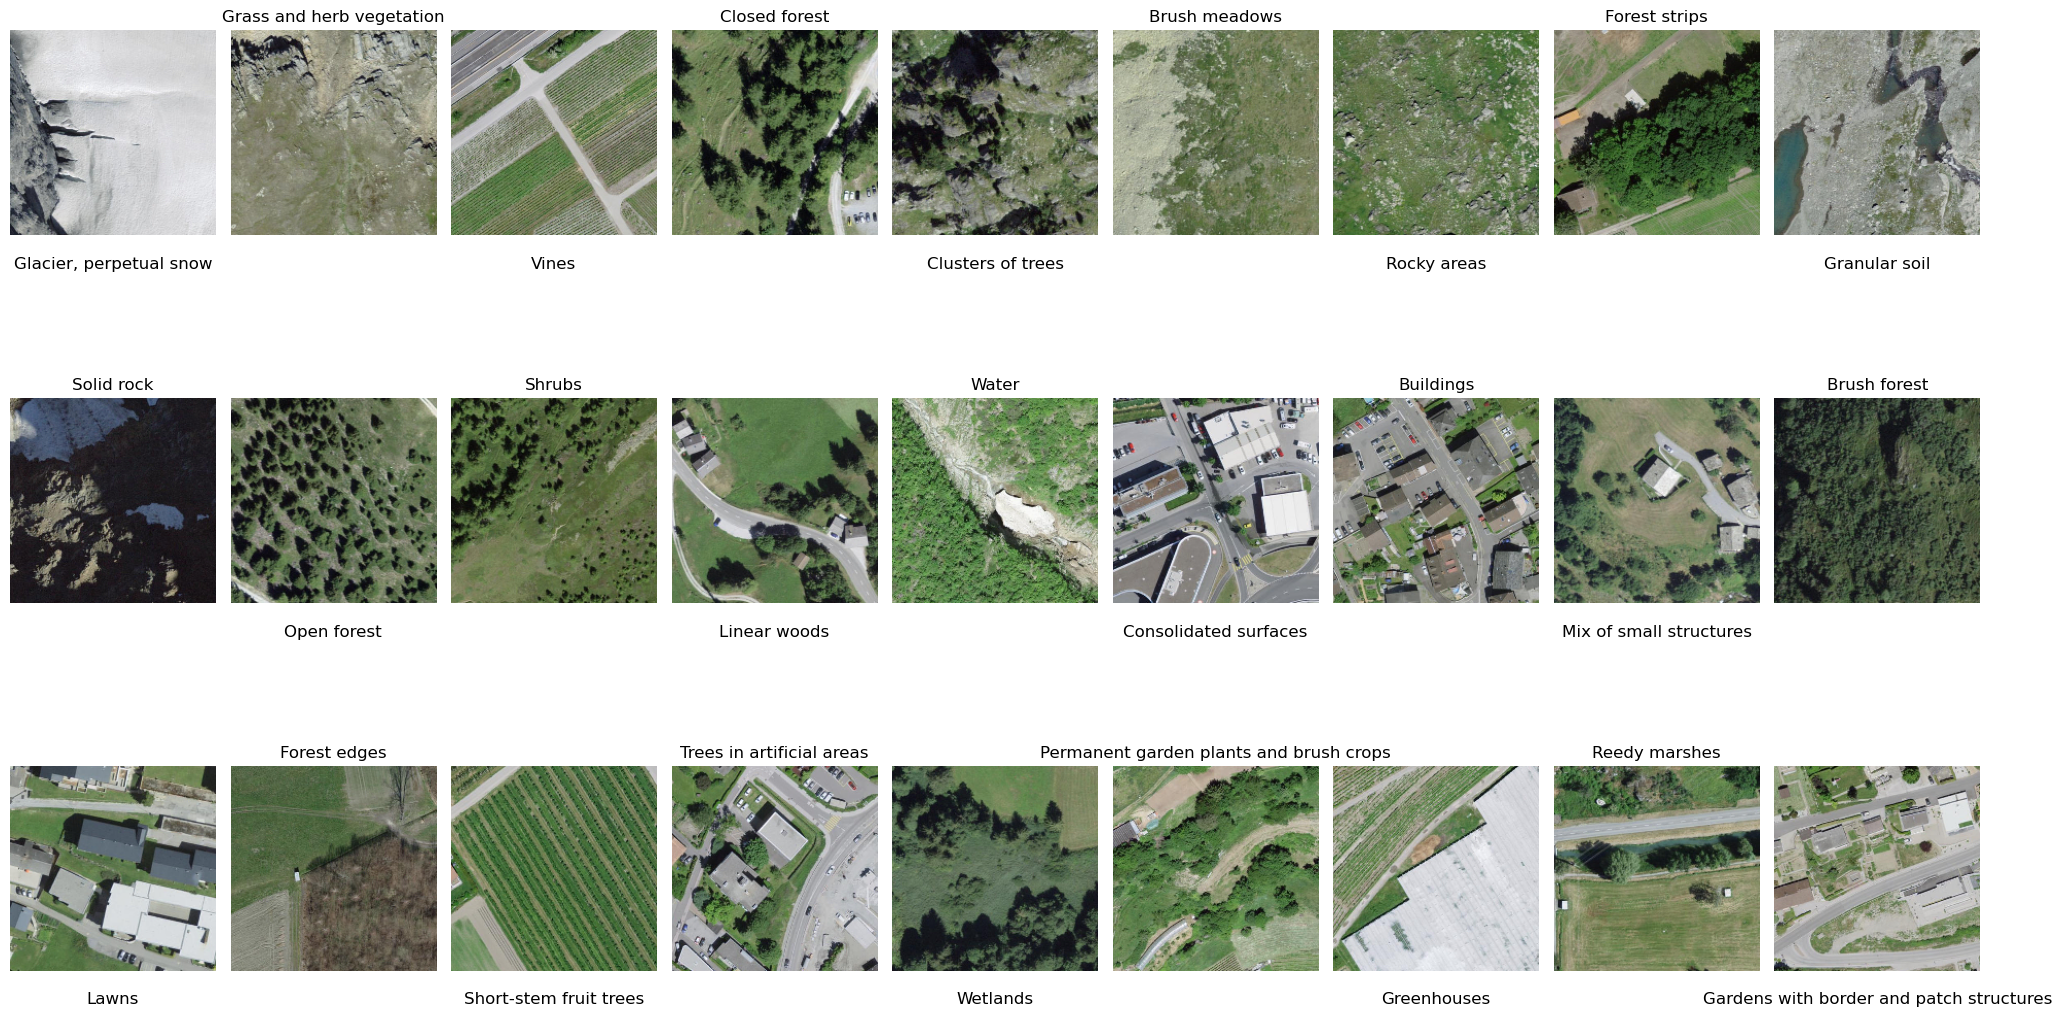

In [40]:
import os

# Preview a sample for each label using the fist encounter with the label

# Dictionary to store all first encounters of "landcover_text" with corresponding "rgb_path"
first_encounters = []

# Set to track unique "landcover_text" values
unique_landcover_texts = set()

for entry in data:
    landcover_text = entry["landcover_text"]
    if landcover_text not in unique_landcover_texts:
        unique_landcover_texts.add(landcover_text)
        first_encounters.append({"landcover_text": landcover_text, "rgb_path": entry["rgb_path"]})


# Create a subplot grid with 3 rows and 9 columns
fig, axs = plt.subplots(3, 9, figsize=(20, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate through both first_encounters and axs simultaneously
counter = 0
for encounter, ax in zip(first_encounters, axs):
    counter = counter + 1
    # Read the image
    img = plt.imread(os.path.join('Dataset/rgb/', encounter["rgb_path"]))

    # Display the image
    ax.imshow(img)

    if(counter % 2): # If the landcover_text is too long, put the title below the image
        ax.set_title(encounter["landcover_text"], y = -0.2)
    else: # Otherwise, put the title above the image
        ax.set_title(encounter["landcover_text"])

    # Hide axes ticks and labels for better visualization
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### 2.1.2 Inspect multi labels

In [41]:
import pandas as pd
multilabel_texts = [entry["multilabel_text"] for entry in data]# if entry.get("split") == "val"])

entry_counts_multi = Counter(multilabel_texts)
entry_counts_multi_sorted = dict(sorted(entry_counts_multi.items(), key=lambda item: item[1], reverse=True))

df = pd.DataFrame(list(entry_counts_multi_sorted.items()), columns=['Multi_Labels', 'Number of Occurrences'])
#pd.set_option("display.max_rows", None)
print(len(entry_counts_multi_sorted), " unique multi-labeled classes.") # Treating them as a single class each will be challenging

638  unique multi-labeled classes.


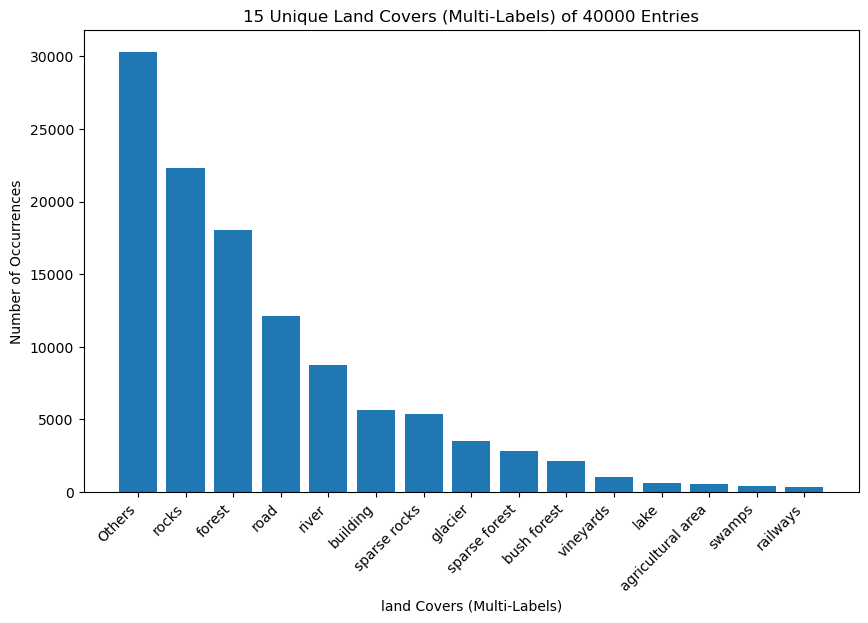

In [7]:
df_summarised = (
    df.assign(Multi_Labels=df['Multi_Labels'].str.split('; '))
    .explode('Multi_Labels')
    .groupby('Multi_Labels', as_index=False)
    .agg({'Number of Occurrences': 'sum'})
    .sort_values('Number of Occurrences', ascending=False)
)

plt.figure(figsize=(10, 6))
plt.bar(df_summarised['Multi_Labels'], df_summarised['Number of Occurrences'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('land Covers (Multi-Labels)')
plt.ylabel('Number of Occurrences')
plt.title(f"{len(df_summarised)} Unique Land Covers (Multi-Labels) of {len(landcover_texts)} Entries")
plt.show()

#### 2.1.3 Inspect train, validation and test splits

In [42]:
# Summary of the splits
total_entries = len(data)
train_entries = sum(entry.get("split") == "train" for entry in data)
val_entries = sum(entry.get("split") == "val" for entry in data)
test_entries = sum(entry.get("split") == "test" for entry in data)

print(f"Total entries: {total_entries}")
print(f"Entries with 'split': 'train': {train_entries} {train_entries/total_entries*100:.2f}%")
print(f"Entries with 'split': 'val': {val_entries} {val_entries/total_entries*100:.2f}%")
print(f"Entries with 'split': 'test': {test_entries} {test_entries/total_entries*100:.2f}%")

Total entries: 40000
Entries with 'split': 'train': 24000 60.00%
Entries with 'split': 'val': 4000 10.00%
Entries with 'split': 'test': 12000 30.00%


Test splits per landcover class (Sinlge label)

In [43]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame(data)

from statsmodels.graphics.mosaicplot import mosaic

subset_df = (
    df[['landcover_text', 'split']]
    .groupby(['split', 'landcover_text'])
    .size()
    .reset_index(name='count')
)

# Calculate proportions
subset_df['proportion'] = subset_df.groupby(['landcover_text'])['count'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot using plotly express
fig = px.bar(subset_df, x='landcover_text', y='proportion', color='split',
             title='Data splits appear to be off balanced per landcover class',
             labels={'landcover_text': 'Landcover Text', 'proportion': 'Proportion (%)'},
             category_orders={'split': sorted(subset_df['split'].unique())})

# Show the plot
fig.show()


Test splits per landcover class (Mutli label)

In [44]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame(data)

from statsmodels.graphics.mosaicplot import mosaic

subset_df = (
    df[['multilabel_text', 'split']]
    .assign(multilabel_text=df['multilabel_text'].str.split('; '))
    .explode('multilabel_text')
    .groupby(['split', 'multilabel_text'])
    .size()
    .reset_index(name='count')
)

# Calculate proportions
subset_df['proportion'] = subset_df.groupby(['multilabel_text'])['count'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot using plotly express
fig = px.bar(subset_df, x='multilabel_text', y='proportion', color='split',
             title='Data splits appear to be well balanced per Multilabel class',
             labels={'multilabel_text': 'Multilabel Text', 'proportion': 'Proportion (%)'},
             category_orders={'split': sorted(subset_df['split'].unique())})

# Show the plot
fig.show()

### 2.2 Write a PyTorch Dataset Class

In [45]:
from torch.utils.data import Dataset

from PIL import Image

import numpy as np

class Valais(Dataset):
    # Labels for Land cover (NOLC04) - Federal Statistical Office | Data in 'Valais Dataset/landcover_labels.txt' switch to labels starting from 0 for compatibility
    LAND_COVER_MAPPING = {
    "Consolidated surfaces": 0,
    "Buildings": 1,
    "Greenhouses": 2,
    "Gardens with border and patch structures": 3,
    "Lawns": 4,
    "Trees in artificial areas": 5,
    "Mix of small structures": 6,
    "Grass and herb vegetation": 7,
    "Shrubs": 8,
    "Brush meadows": 9,
    "Short-stem fruit trees": 10,
    "Vines": 11,
    "Permanent garden plants and brush crops": 12,
    #"Tree vegetation": 13, # Not in data set
    "Closed forest": 13,
    "Forest edges": 14,
    "Forest strips": 15,
    "Open forest": 16,
    "Brush forest": 17,
    "Linear woods": 18,
    "Clusters of trees": 19,
    # "Bare land": 21, # Not in data set
    "Solid rock": 20,
    "Granular soil": 21,
    "Rocky areas": 22,
    # "Watery areas": 25, # Not in data set
    "Water": 23,
    "Glacier, perpetual snow": 24,
    "Wetlands": 25,
    "Reedy marshes": 26
}
    
    # Labels from Swiss Topographic Landscape Model (TLM) from Swisstopo | Data provided in 'Valais Dataset/multilabel_classes.txt'
    MULTI_LABEL_Mapping = {
    "Others": 0, # Changed from background to others to match data set
    "agricultural area": 1,
    "building": 2,
    "bush forest": 3,
    "forest": 4,
    "glacier": 5,
    "lake": 6,
    #"pedestrian path": 7,          # Not in dataset
    #"public leisure area": 8,      # Not in dataset
    "railways": 7,
    "river": 8,
    "road": 9,
    "rocks": 10,
    "sparse forest": 11,
    "sparse rocks": 12,
    "swamps": 13,
    "vineyards": 14
}

    
    # Not necessary as images are labelled to be val, test or train, Thanks :)
    # np.random.seed(9)
    # data_size = 10 # Number of images to be used for training, validation and testing
    # train_size = int(5/8 * data_size)
    # val_size = int(1/8 * data_size)
    
    # train_indices = np.random.choice(range(data_size), size=train_size, replace=False)
    # val_indices = np.random.choice(np.setdiff1d(range(data_size), train_indices), size = val_size, replace=False)
    # test_indices = np.setdiff1d(range(data_size), np.concatenate((train_indices, val_indices)))

    train_indices = [index for index, entry in enumerate(data) if entry.get("split") == "train"]
    val_indices = [index for index, entry in enumerate(data) if entry.get("split") == "val"]
    test_indices = [index for index, entry in enumerate(data) if entry.get("split") == "test"]

    SPLITS = {
        "train": train_indices,
        "val": val_indices,
        "test": test_indices
    }

    def __init__(self, split="train", transforms=None, multi_label_classification = False):
        self.transforms = transforms

        self.data = []  # list of tuples of (image path, label class)
        
        # get images with correct index according to dataset split
        for imgIndex in self.SPLITS[split]:
            imgName = data[imgIndex]["rgb_path"]
            if multi_label_classification:
                imgLabel = np.zeros(len(self.MULTI_LABEL_Mapping)).astype(int)
                multi_label_string = data[imgIndex]["multilabel_text"]
                multi_class_values_np = np.array([value.strip() for value in multi_label_string.split(';')])
                for label in multi_class_values_np:
                    imgLabel[self.MULTI_LABEL_Mapping[label]] = 1
                self.data.append((
                    imgName,
                    imgLabel
                ))
            else:
                imgLabel = data[imgIndex]["landcover_text"]
                # example format: 'baseFolder/agricultural/agricultural07.tif'
                self.data.append((
                    imgName,
                    self.LAND_COVER_MAPPING[imgLabel]          # get index for label class
                ))

    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, index):
        # TODO retrieve the item from self.data at position index
        imgName, label = self.data[index]

        # TODO load the image array from the imgName
        img = Image.open(os.path.join('Dataset/rgb/',imgName)).convert('RGB')
        # TODO apply transformation
    
        if self.transforms is not None:
            img = self.transforms(img)
        return img, label

Check that the ys (true labels) are stored as intended for multi-labels

In [46]:
import os
dataset = Valais(split="train", multi_label_classification = False)

dataset_index = 3

img, label = dataset[dataset_index]
print(label)

13


In [13]:
# Another way to convert multi-labels to single label classes
# df = pd.DataFrame(data)

# # Separate comma-separated values into separate rows
# df = df.assign(multilabel_text=df['multilabel_text'].str.split('; ')).explode('multilabel_text')

# # Create a column of 1s for each unique text value
# df['indicator'] = 1

# # Pivot wider based on unique text values
# df_wide = df.pivot_table(index='rgb_path', columns=['multilabel_text'], values='indicator', fill_value=0)

# # Reset index to make 'id' a regular column
# df_wide.reset_index(inplace=True)

# # Print the result
# df_wide[1:3]

#### 2.2.1 Check if dataset class works

In [47]:
# initialize the dataset (call the constructor __init__)
dataset = Valais() # only train split by default
print(f"dataset of length {len(dataset)}")

# plot individual samples
import matplotlib.pyplot as plt
from ipywidgets import interact

# @interact(idx=range(len(dataset))) # Too big causing crash
@interact(idx=range(0,1000))
def plot_sample(idx=0):
    img, label = dataset[idx]

    # swaps keys and values in the dictionary UCMerced.LABEL_CLASSES
    class_mapping = {v: k for k, v in Valais.LAND_COVER_MAPPING.items()}

    fig, axs = plt.subplots(1, 1, figsize=(4, 4))

    plt.title(f"classid {label} ({class_mapping[label]})")

    plt.imshow(img)

dataset of length 24000


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

### 2.3 Define custom transforms

In [15]:
# import os
# from PIL import Image
# import torch
# from torchvision import transforms

# # Define your dataset path and transform without normalization
# dataset_path = 'Valais Dataset/rgb/'
# transform = transforms.Compose([transforms.ToTensor()])

# # Get a list of image file paths
# image_paths = [os.path.join(dataset_path, img) for img in os.listdir(dataset_path) if img.endswith(('.tif'))]

# # Initialize variables to accumulate the sum and sum of squares
# mean_sum = torch.zeros(3)
# std_sum = torch.zeros(3)

# # Loop through the images and compute the sum and sum of squares
# for img_path in image_paths:
#     img = Image.open(img_path)
#     img = transform(img)
#     mean_sum += img.mean(dim=[1, 2])
#     std_sum += img.std(dim=[1, 2])

# # Calculate the mean and standard deviation
# mean = mean_sum / len(image_paths)
# std = std_sum / len(image_paths)

# print("Calculated mean:", mean)
# print("Calculated std:", std)

In [48]:
import torchvision.transforms as T
import numpy as np

# mean and standard deviation of the dataset # Number are computed from previous cell
mean=torch.tensor([0.4215, 0.4603, 0.3775])
std=torch.tensor([0.1379, 0.1375, 0.1301])

# normalize image [0-1] (or 0-255) to zero-mean unit standard deviation
normalize = T.Normalize(mean, std)
# we invert normalization for plotting later
std_inv = 1 / (std + 1e-7)
unnormalize = T.Normalize(-mean * std_inv, std_inv)

transforms_train = T.Compose([
    T.RandomResizedCrop((180, 180)), # Original size is 200x200
    T.RandomGrayscale(p=0.1),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.RandomPosterize(bits=4, p=0.2),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.Resize((200, 200)),
    T.ToTensor(),
  normalize
])

# we do not augment the validation dataset (aside from resizing and tensor casting)
transforms_val = T.Compose([
  T.Resize((200, 200)), # No need they are 200 x 200 anyways
  T.ToTensor(),
  normalize
])

transforms_test = T.Compose([
  T.Resize((200, 200)), # No need they are 200 x 200 anyways
  T.ToTensor(),
  normalize
])

#### 2.3.1 Check if transforms work

[(-0.5, 199.5, 199.5, -0.5), (-0.5, 199.5, 199.5, -0.5)]

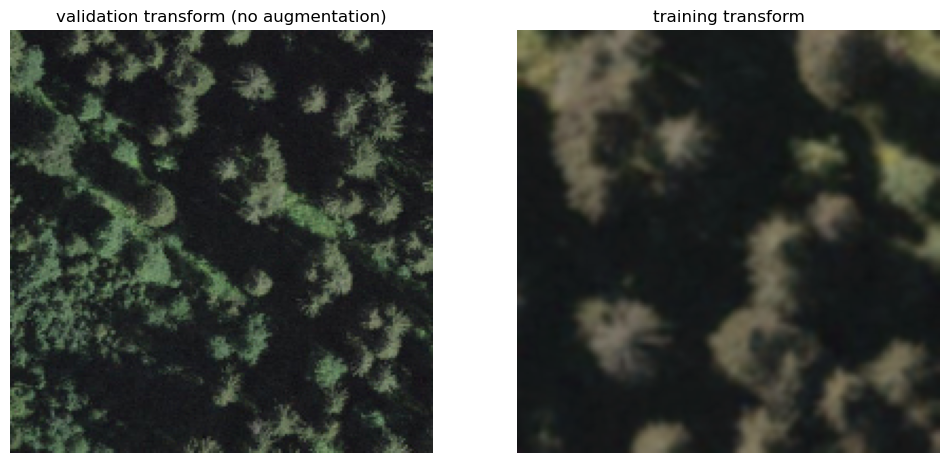

In [49]:
dataset_index = 320

img, label = dataset[dataset_index]

fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].imshow(unnormalize(transforms_val(img)).permute(1,2,0))
axs[0].set_title("validation transform (no augmentation)")

axs[1].imshow(unnormalize(transforms_train(img)).permute(1,2,0))
axs[1].set_title("training transform")
[ax.axis("off") for ax in axs] # removes ticks

### 2.3 Create train and validation data loaders

## 3. Train model - Single Label Classification

Create train and validation data loaders

In [50]:
train_dataset = Valais(split = 'train', transforms = transforms_train, multi_label_classification = False)
val_dataset = Valais(split = 'val', transforms=transforms_val, multi_label_classification = False)
test_dataset = Valais(split = 'test', transforms = transforms_test, multi_label_classification = False)

In [51]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_dataset , batch_size=16, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=None,
           persistent_workers=False)

val_dl = DataLoader(val_dataset , batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=None,
           persistent_workers=False)

test_dl = DataLoader(test_dataset , batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=None,
           persistent_workers=False)

### 3.1 AlexNet Architecture

#### 3.1.1 Development

In [52]:
from torch import nn

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()

        ## features here do not mean X_1, X_2, ...etc. In a convolutional NN it's the set of operations, jumping from one layer to the
        ## next- Notice that that as we jump the # input parameters in = the #output parameters of prev layers.
        ## Notice also that as you jump we may increase or decrease the # output parameters as we see fit.
        self.features = nn.Sequential(
            # 11x11 convolution from 3 to 64 channels, stride 4, padding 2
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            # 3x3 Maxpool with stride 2
            nn.MaxPool2d(kernel_size=3, stride=2),

            # 5x5 convolution from 64 to 192 channels and padding 2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            # 3x3 Maxpool with stride 2
            nn.MaxPool2d(kernel_size=3, stride=2),

            # 3x3 convolution from 192 to 384 channels and padding 1
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # 3x3 convolution from 384 to 256 channels and padding 1
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # 3x3 convolution from 256 to 256 channels and padding 1
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # 3x3 Maxpool with stride 2
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        ## Fully connected NN basically after all the CNN layers
        self.classifier = nn.Sequential(
            # Dropout
            nn.Dropout(dropout),
            # Linear with 256*6*6 to 4096 channels
            nn.Linear(in_features = 256*6*6, out_features =4096),
            # inplace ReLU
            nn.ReLU(inplace=True), #If false it creates a new tensor and stores the result there. Would not track for the forward pass.
            # Dropout
            nn.Dropout(dropout),
            # Linear with 4096 to 4096 channels
            nn.Linear(in_features = 4096, out_features = 4096),
            # inplace ReLU
            nn.ReLU(inplace=True),
            # Linear with 4096 to num_classes channels
            nn.Linear(in_features = 4096, out_features = num_classes) )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Recall that in all the sequentials we initialised - so to say - the layers but we did not pass our feature tensor yet. Similar to the
        # code we wrote earlier in the above cells we would do convlayer = nn.conv2d(,,,,) and then do x=convlayer(x) now we have sqn!
        x = self.features(x)    # apply features sub-module
        x = self.avgpool(x)     # apply average pooling sub-module
        x = torch.flatten(x, 1) # <== of course we need to have it as a vector to do fully connected NN :)
        x = self.classifier(x)  # apply classifier sub.module
        return x


# Notice this class does not have the methods predict or step, i.e it does not do any training!
# THE CONSTRUCTOR HOWEVER DOES PREDICTION(ForwardPass) AUTOMATICALLY!! model = AlexNet(num_classes = XX) -> model(x) contains logits information

In [53]:
# Load the model :
model = AlexNet(num_classes=27)

#### 3.1.2 Training (AlexNet)

In [54]:
#%pip install -q -U pytorch_lightning tensorboard
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from pytorch_lightning.callbacks import ModelCheckpoint

import torch.nn as nn
import torch.nn.functional as F

class PLWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", (y_hat.argmax(1) == y).float().mean())

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=0.01)

In [55]:
plmodel = PLWrapper(model)

tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs/")

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='alexnet-{epoch}-{val_accuracy:.2f}',
    monitor="val_accuracy",
    mode="max"
    )

trainer = pl.Trainer(accelerator="gpu",
                        logger=tb_logger, callbacks=[checkpoint_callback])

trainer.fit(plmodel, train_dataloaders=train_dl, val_dataloaders=val_dl,ckpt_path="checkpoints/alexnet-epoch=63-val_accuracy=0.56.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\horst\anaconda3\Lib\site-packages\pytorch_lightning\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
C:\Users\horst\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\horst\Desktop\Image-Processing-For-Earth-Observation-main\Image-Processing-For-Earth-Observation-main\Wallis-Multi-Label-Classification\checkpoints exists and is not empty.
Restoring states from the checkpoint path at checkpoints/alexnet-epoch=63-val_accuracy=0.56.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | AlexNet | 57.1 M
----------------------------------
57.1 M    Trainable params
0         Non-trainable params
57.1 M    Total params
228.458  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\horst\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\horst\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\horst\anaconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [56]:
#!pip install -q -U pytorch_lightning tensorboard
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from pytorch_lightning.callbacks import ModelCheckpoint

import torch.nn as nn
import torch.nn.functional as F

In [58]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/ --port=6009

#### 3.1.3 Testing (AlexNet)

In [59]:
from tqdm.auto import tqdm
state_dict = torch.load("checkpoints/alexnet-epoch=63-val_accuracy=0.56.ckpt")["state_dict"]
state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
# Update the model weights by calling load_state_dict on the model
model.load_state_dict(state_dict)

y_preds, y_trues = [], [] 

device = "cuda"
model = model.to(device)

# Attempt to treat class imbalance
#################################################################
# Weights corresponding to the data set dictionary

counts = torch.tensor([]).int()
for i in entry_counts:
    for j in range(len(entry_counts)):
        if i == list(entry_counts.keys())[j]:
            counts = torch.cat((counts, torch.tensor([entry_counts[i]])))


weights = counts / len(landcover_texts)
inverse_weights = 1 / weights
inverse_weights_weighted = inverse_weights / inverse_weights.sum()
#################################################################

with torch.no_grad():
    for x,y in tqdm(test_dl, total=len(test_dl)):
        x = x.to(device)
        y = y.to(device)
        #inverse_weights = inverse_weights.to(device)
        
        logits = model(x)
        #logits = torch.log(inverse_weights) * logits
        y_pred = logits.argmax(1)
        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y.cpu().numpy())

y_preds = np.hstack(y_preds)
y_trues = np.hstack(y_trues)

  0%|          | 0/750 [00:00<?, ?it/s]

In [36]:
# Overall accuracy
overall_accuracy = (y_preds == y_trues).mean()
print(overall_accuracy)

0.5551666666666667


In [75]:
# Classification Report
from sklearn.metrics import classification_report
import pandas as pd

# the names of all classes
target_names = list(dataset.LAND_COVER_MAPPING.keys())

# print the classification report
report = classification_report(y_trues, y_preds, target_names=target_names)
print(report)


                                          precision    recall  f1-score   support

                   Consolidated surfaces       0.25      0.36      0.30       340
                               Buildings       0.16      0.39      0.22        95
                             Greenhouses       0.00      0.00      0.00         1
Gardens with border and patch structures       0.00      0.00      0.00        12
                                   Lawns       0.00      0.00      0.00        85
               Trees in artificial areas       0.00      0.00      0.00        45
                 Mix of small structures       0.00      0.00      0.00        20
               Grass and herb vegetation       0.58      0.70      0.64      2645
                                  Shrubs       0.14      0.48      0.22       409
                           Brush meadows       0.14      0.30      0.19       444
                  Short-stem fruit trees       0.52      0.44      0.47        73
               

C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


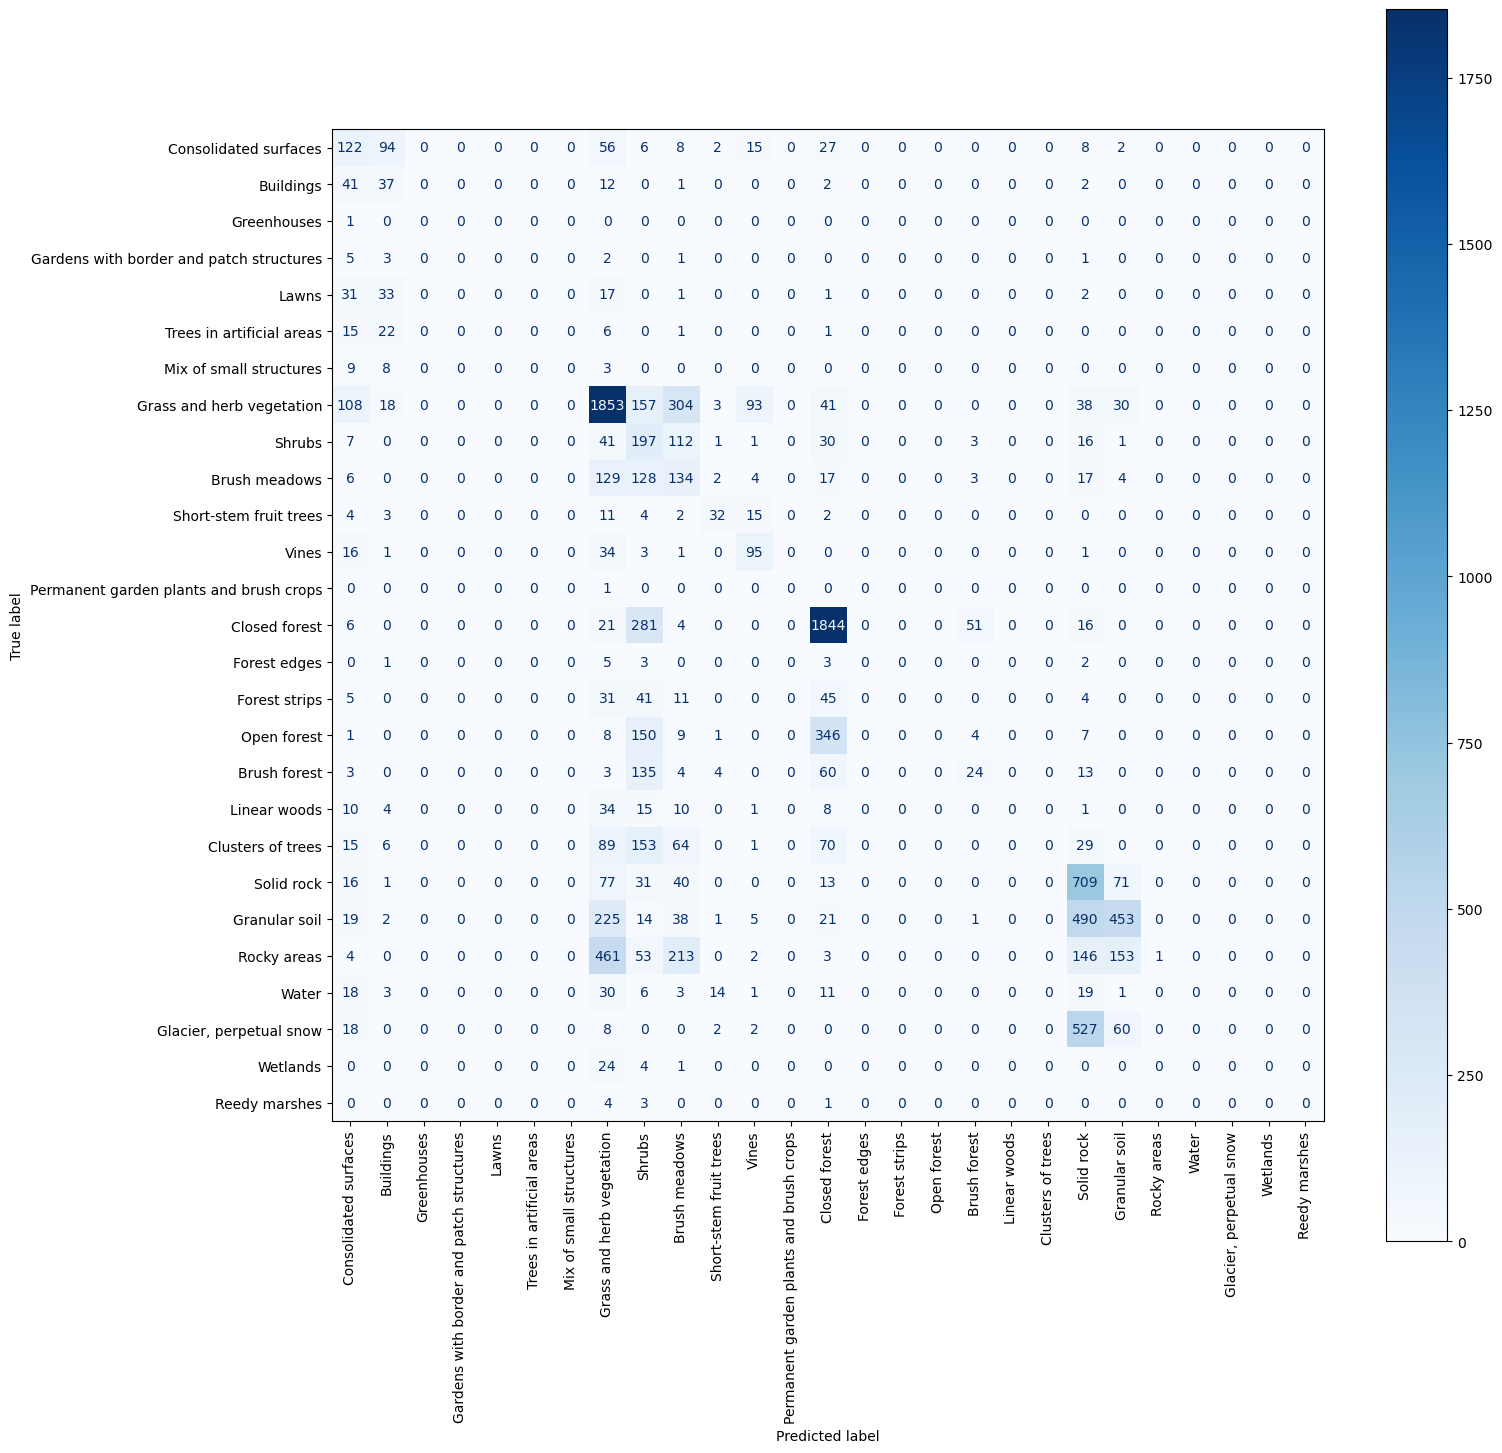

In [76]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

land_cover_labels = []
for label in dataset.LAND_COVER_MAPPING.keys():
    land_cover_labels.append(label)
    
fig, ax = plt.subplots(figsize=(16, 16))

display = ConfusionMatrixDisplay.from_predictions(y_trues, y_preds,
                      display_labels=land_cover_labels, xticks_rotation=90, cmap="Blues", ax=ax)


plt.show()

### 3.2 ResNet18 and ResNet50 Architecture

#### 3.2.1 Model import

Important instruction: Execute ONE of the following to load either the ResNet-18 or -50 architecture:

In [23]:
from torchvision.models import resnet18

# load a resnet18 with 27 classes
model = resnet18(num_classes=27)

In [26]:
from torchvision.models import resnet50

# load a resnet50 with 27 classes
model = resnet50(num_classes=27)

#### 3.2.2 Training (ResNet)

In [21]:
#%pip install -q -U pytorch_lightning tensorboard
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from pytorch_lightning.callbacks import ModelCheckpoint

import torch.nn as nn
import torch.nn.functional as F

class PLWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", (y_hat.argmax(1) == y).float().mean())

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=0.01)

#### important instruction: before running this cell, set the filename to the respective resnet architecture (50 or 18) in line 7

In [27]:
plmodel = PLWrapper(model)

tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs/single_label/res50/")

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='resnet50-{epoch}-{val_accuracy:.2f}',
    monitor="val_accuracy",
    mode="max"
    )

trainer = pl.Trainer(max_epochs=200, accelerator="gpu",
                        logger=tb_logger, callbacks=[checkpoint_callback])

trainer.fit(plmodel, train_dataloaders=train_dl, val_dataloaders=val_dl, ckpt_path="checkpoints/resnet50-epoch=47-val_accuracy=0.56.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/single_label/res50/lightning_logs
Restoring states from the checkpoint path at checkpoints/resnet50-epoch=47-val_accuracy=0.56.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.6 M
---------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.253    Total estimated model params size (MB)
Restored all states from the checkpoint at checkpoints/resnet50-epoch=47-val_accuracy=0.56.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

#### 3.2.3 Testing (ResNet)

important instruction: before running this cell, make sure to load the correct architecture as a checkpoint in line 2 (ResNet 18 or 50)

In [29]:
from tqdm.auto import tqdm
state_dict = torch.load("checkpoints/resnet50-epoch=47-val_accuracy=0.56.ckpt")["state_dict"]
state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
# Update the model weights by calling load_state_dict on the model
model.load_state_dict(state_dict)

y_preds, y_trues = [], [] 

device = "cuda"
model = model.to(device)

# Attempt to treat class imbalance
#################################################################
# Weights corresponding to the data set dictionary

counts = torch.tensor([]).int()
for i in entry_counts:
    for j in range(len(entry_counts)):
        if i == list(entry_counts.keys())[j]:
            counts = torch.cat((counts, torch.tensor([entry_counts[i]])))
weights = counts / len(landcover_texts)

#inverse_weights = 1 / weights
#inverse_weights_weighted = inverse_weights / inverse_weights.sum()
#################################################################

with torch.no_grad():
    for x,y in tqdm(test_dl, total=len(test_dl)):
        x = x.to(device)
        y = y.to(device)
        #inverse_weights_weighted= inverse_weights_weighted.to(device)
        
        logits = model(x)
        #logits = -torch.log(inverse_weights_weighted)*logits
        y_pred = logits.argmax(1)
        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y.cpu().numpy())
        
y_preds = np.hstack(y_preds)
y_trues = np.hstack(y_trues)        

  0%|          | 0/750 [00:00<?, ?it/s]

In [65]:
# Overall accuracy
overall_accuracy = (y_preds == y_trues).mean()
print(overall_accuracy)

0.5805


In [66]:
# Classification Report
from sklearn.metrics import classification_report

# the names of all classes
target_names = list(dataset.LAND_COVER_MAPPING.keys())

# print the classification report
print(classification_report(y_trues, y_preds, target_names=target_names))

                                          precision    recall  f1-score   support

                   Consolidated surfaces       0.34      0.47      0.40       340
                               Buildings       0.00      0.00      0.00        95
                             Greenhouses       0.00      0.00      0.00         1
Gardens with border and patch structures       0.00      0.00      0.00        12
                                   Lawns       0.00      0.00      0.00        85
               Trees in artificial areas       0.00      0.00      0.00        45
                 Mix of small structures       0.00      0.00      0.00        20
               Grass and herb vegetation       0.60      0.80      0.69      2645
                                  Shrubs       0.37      0.27      0.31       409
                           Brush meadows       0.27      0.04      0.07       444
                  Short-stem fruit trees       0.83      0.14      0.24        73
               

C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


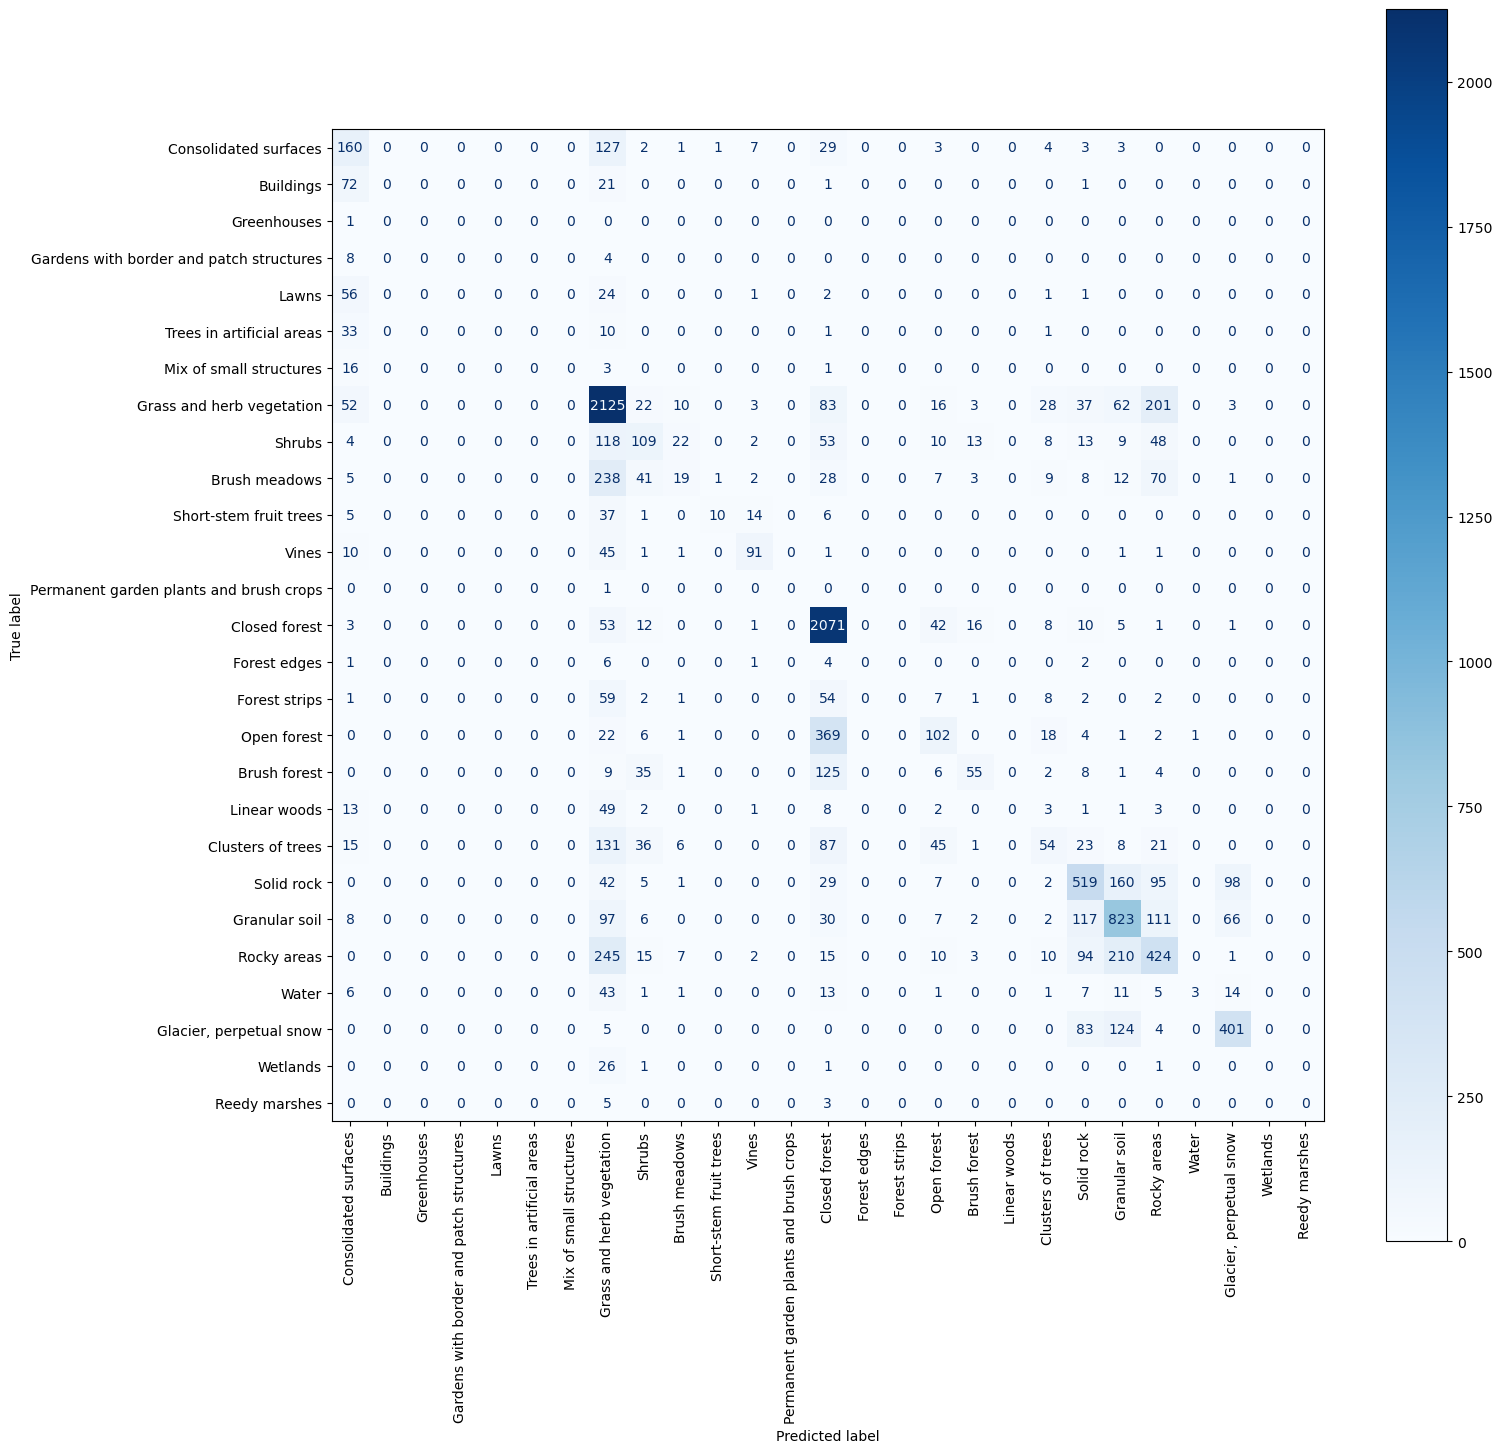

In [67]:
# Generate a Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

land_cover_labels = []
for label in dataset.LAND_COVER_MAPPING.keys():
    land_cover_labels.append(label)
    
fig, ax = plt.subplots(figsize=(16, 16))

display = ConfusionMatrixDisplay.from_predictions(y_trues, y_preds,
                      display_labels=land_cover_labels, xticks_rotation=90, cmap="Blues", ax=ax)


plt.show()

### 3.3 Fine Tuning a Pretrained Model

In [ ]:
import torchvision.models as models

# Load a pretrained model (e.g., ResNet50)
# pretrained_model = models.resnet50(pretrained=True)

# # Modify the output layer to match the number of classes in your new dataset
# num_classes = 27
# pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

# # Assuming you have a DataLoader for your new dataset called `data_loader`
# # Define loss function, optimizer, etc.
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# # Fine-tune the model on your new dataset
# num_epochs = 5
# for epoch in range(num_epochs):
#     for inputs, labels in train_dl:
#         optimizer.zero_grad()
#         outputs = pretrained_model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

## 4- Train model - Multi Label Classification

We follow the approach such that final layer is of the same size as the number of multiple labels. We also apply the sigmoid function to the final layer to get the probabilities of each label. After obtaining the results we apply different thresholds using the ROC curvee to get the final labels.

Create and train and validation data loaders

In [61]:

train_dataset = Valais(split = 'train' , transforms=transforms_train, multi_label_classification = True)
val_dataset = Valais(split = 'val', transforms=transforms_val, multi_label_classification = True)
test_dataset = Valais(split = 'test', transforms=transforms_test, multi_label_classification = True)

In [62]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_dataset , batch_size=100, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=None,
           persistent_workers=False)

val_dl = DataLoader(val_dataset , batch_size=100, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=None,
           persistent_workers=False)

test_dl = DataLoader(test_dataset , batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=None,
           persistent_workers=False)

### 4.1 AlexNet Architecture
We adjust the final to have 15 neurons with Sigmoid activation function for multi label classification.

#### 4.1.1 Development

In [63]:
#%pip install -q -U pytorch_lightning tensorboard
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from pytorch_lightning.callbacks import ModelCheckpoint

import torch.nn as nn
import torch.nn.functional as F

class PLWrapperMultilabel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())  # Use binary cross-entropy
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO; MAKE IT THE SAME AS TESTING!!!!
        x, y = batch
        y_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())  # Use binary cross-entropy
        preds = (torch.sigmoid(y_hat) > 0.5).to(torch.int32)

        self.log("val_loss", loss)
        self.log("val_accuracy", torch.mean(torch.mean((preds == y).to(torch.int32), axis=1,dtype=torch.float32)))

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=0.01)

#### 4.1.2 Training

In [81]:
model = AlexNet(num_classes=15)

plmodel = PLWrapperMultilabel(model)

tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs/")

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='alexnet-Multilabel-{epoch}-{val_accuracy:.2f}',
    monitor="val_accuracy",
    mode="max"
    )

trainer = pl.Trainer(max_epochs=1000, accelerator="gpu",
                        logger=tb_logger, callbacks=[checkpoint_callback])

trainer.fit(plmodel, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\horst\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:639: Checkpoint directory C:\Users\horst\Desktop\Image-Processing-For-Earth-Observation-main\Image-Processing-For-Earth-Observation-main\Wallis-Multi-Label-Classification\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | AlexNet | 57.1 M
----------------------------------
57.1 M    Trainable params
0         Non-trainable params
57.1 M    Total params
228.261   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\horst\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\horst\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\horst\anaconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


#### 4.1.3 Testing

In [64]:
from tqdm.auto import tqdm
model = AlexNet(num_classes=15)
state_dict = torch.load("checkpoints/alexnet-Multilabel-epoch=29-val_accuracy=0.88.ckpt")["state_dict"]
state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
# Update the model weights by calling load_state_dict on the model
model.load_state_dict(state_dict)

y_preds, y_trues = np.empty((1,15)), np.empty((1,15)).astype(int)

device = "cuda"
model = model.to(device)

with torch.no_grad():
    for x,y in tqdm(test_dl, total=len(test_dl)):
        x = x.to(device)
        y = y.to(device)
        
        logits = model(x)
        y_pred = torch.sigmoid(logits)
        y_preds = np.vstack((y_preds, y_pred.cpu().numpy()))
        y_trues = np.vstack((y_trues, y.cpu().numpy()))

        
y_preds = y_preds[1:]
y_trues = y_trues[1:]

  0%|          | 0/12000 [00:00<?, ?it/s]

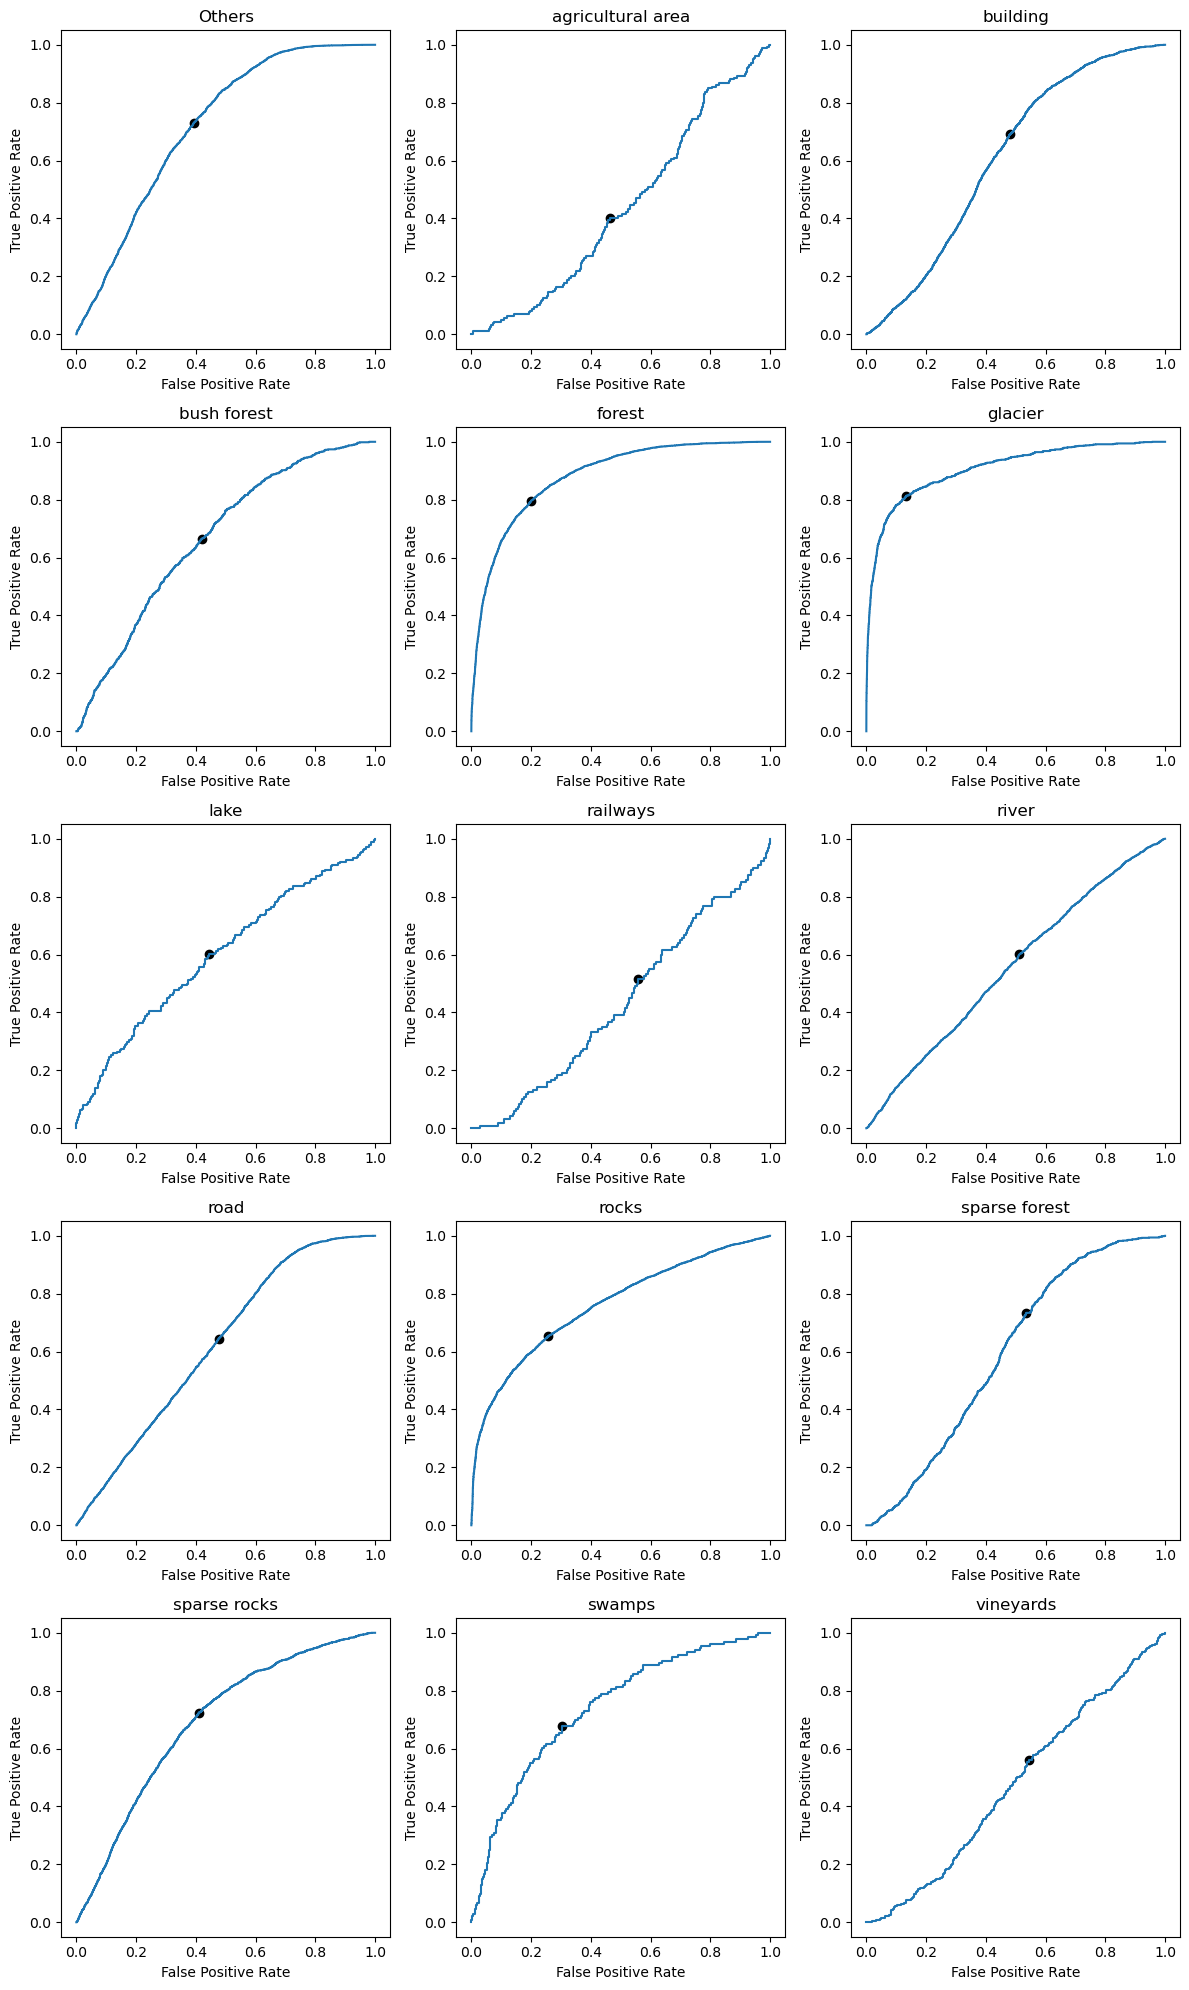

In [156]:
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 3, figsize=(12, 20))

optimal_Thresholds = []
for i in range(15):
    fpr, tpr, thresholds = roc_curve(y_trues[:, i], y_preds[:, i])
    gmeans = np.sqrt(tpr * (1-fpr))
    optimal_Threshold = np.argmax(gmeans)
    optimal_Thresholds.append(optimal_Threshold)
    ax = axs[i//3, i%3]  # Access the correct subplot
    ax.plot(fpr, tpr)
    ax.scatter(fpr[optimal_Threshold], tpr[optimal_Threshold], marker='o', color='black', label='Best')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"{list(dataset.MULTI_LABEL_Mapping.keys())[i]}")


plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [125]:
y_preds_binary = np.empty_like(y_preds)
for i in range(15):
    y_preds_binary[:, i] = (y_preds[:, i] >= optimal_Thresholds[i]).astype(int)

In [126]:
overall_accuracy = (y_preds_binary==y_trues).mean()
print(overall_accuracy)

0.8096472222222222


In [127]:
y_preds_binary = np.empty_like(y_preds)
for i in range(15):
    y_preds_binary[:, i] = (y_preds[:, i] >= 0.5).astype(int)
overall_accuracy = (y_preds_binary==y_trues).mean()
print(overall_accuracy)

0.8761388888888889


In [133]:
for i in range(15):
    print(classification_report(y_trues[:, i], y_preds_binary[:,i]))

              precision    recall  f1-score   support

           0       0.65      0.29      0.40      5822
           1       0.81      0.95      0.87     18178

    accuracy                           0.79     24000
   macro avg       0.73      0.62      0.64     24000
weighted avg       0.77      0.79      0.76     24000

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     23668
           1       0.00      0.00      0.00       332

    accuracy                           0.99     24000
   macro avg       0.49      0.50      0.50     24000
weighted avg       0.97      0.99      0.98     24000

              precision    recall  f1-score   support

           0       0.86      1.00      0.92     20613
           1       0.00      0.00      0.00      3387

    accuracy                           0.86     24000
   macro avg       0.43      0.50      0.46     24000
weighted avg       0.74      0.86      0.79     24000

              preci

C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23774
           1       0.00      0.00      0.00       226

    accuracy                           0.99     24000
   macro avg       0.50      0.50      0.50     24000
weighted avg       0.98      0.99      0.99     24000

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     18683
           1       0.00      0.00      0.00      5317

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000

              precision    recall  f1-score   support

           0       0.70      1.00      0.82     16759
           1       0.00      0.00      0.00      7241

    accuracy                           0.70     24000
   macro avg       0.35      0.50      0.41     24000
weighted avg       0.49      0.70      0.57     24000

              preci

C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\horst\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


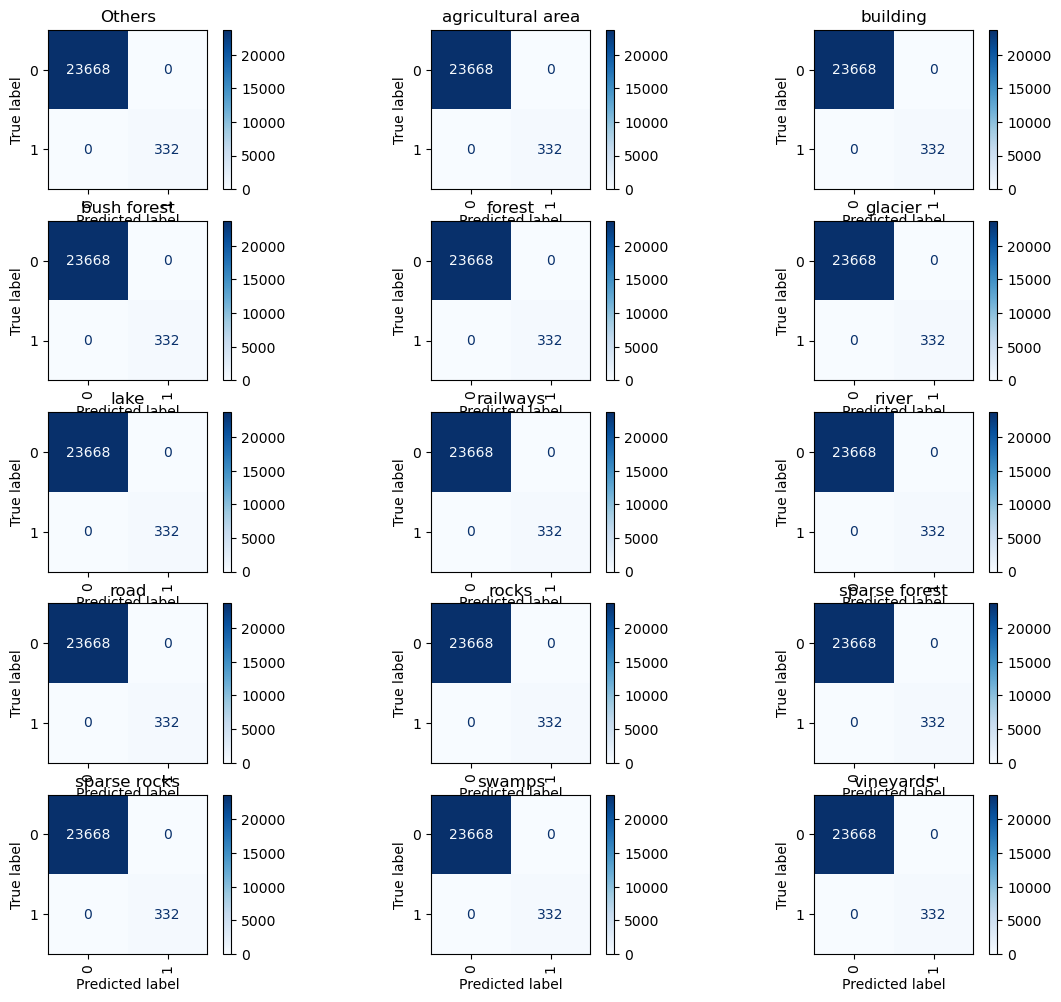

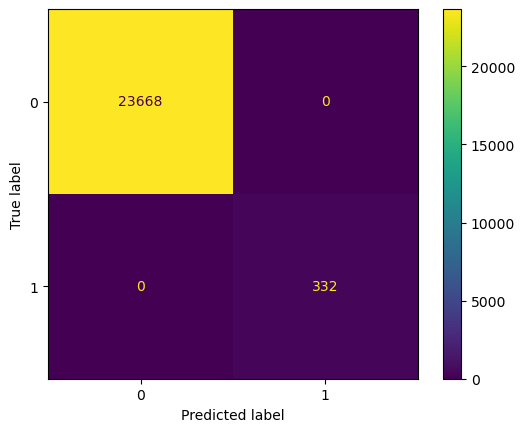

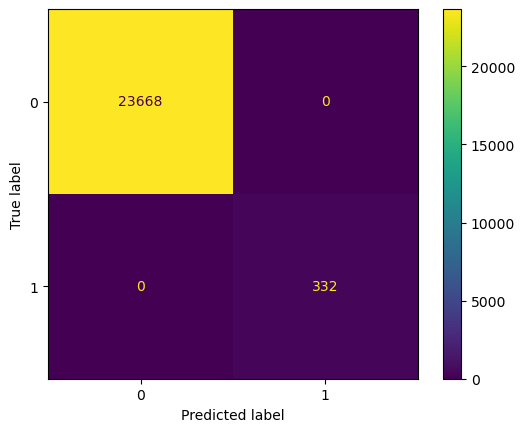

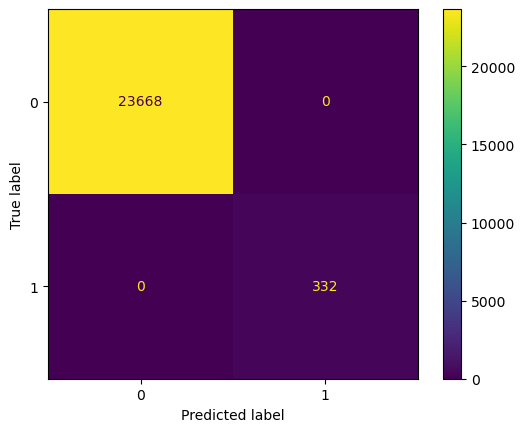

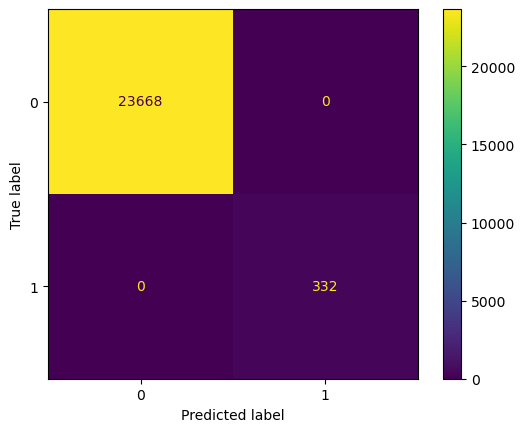

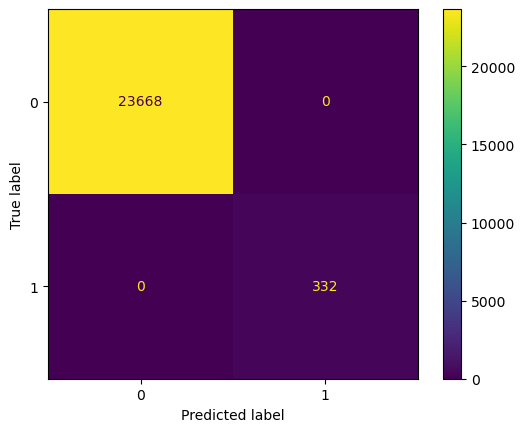

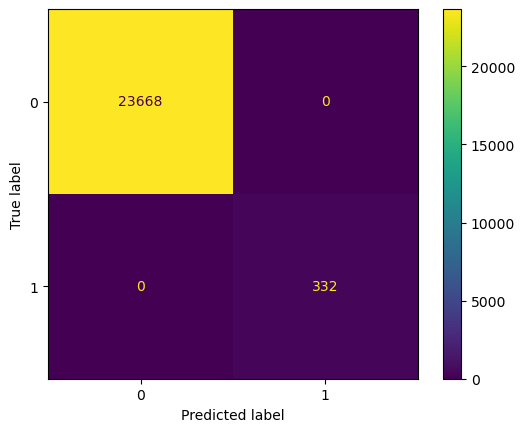

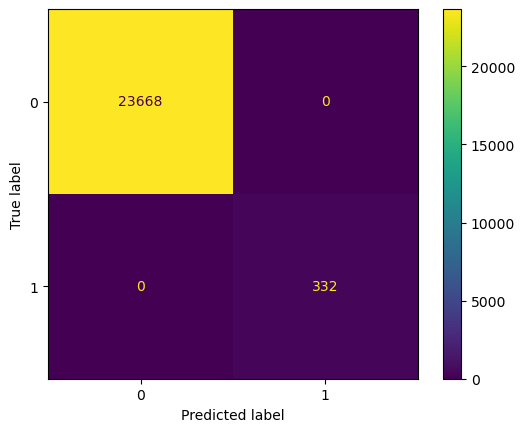

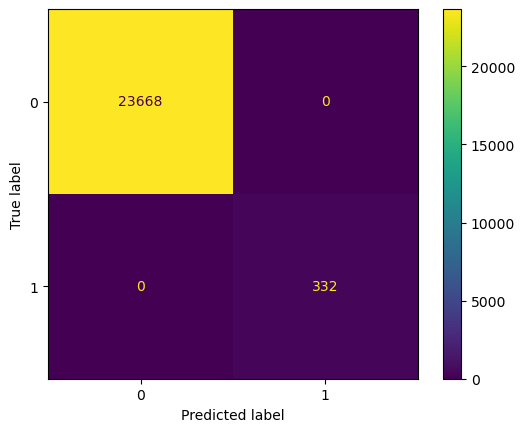

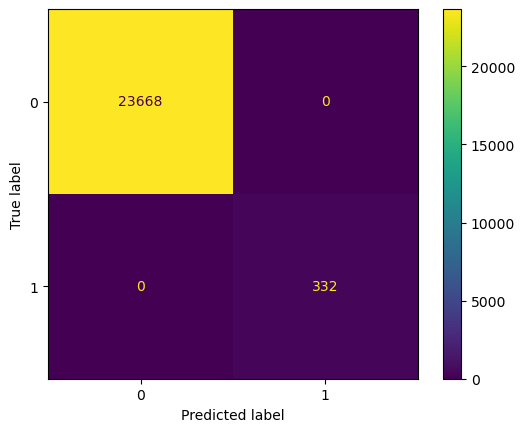

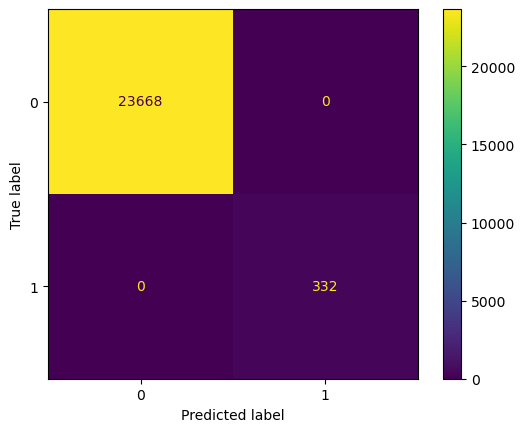

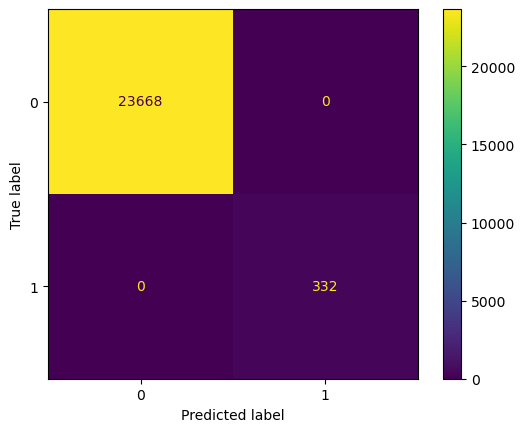

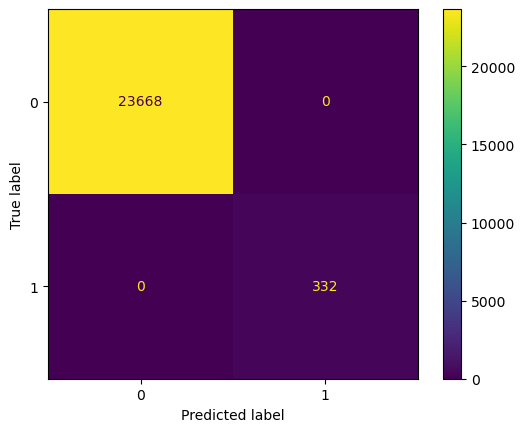

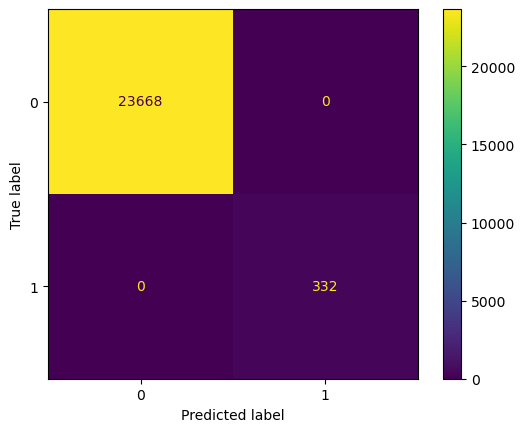

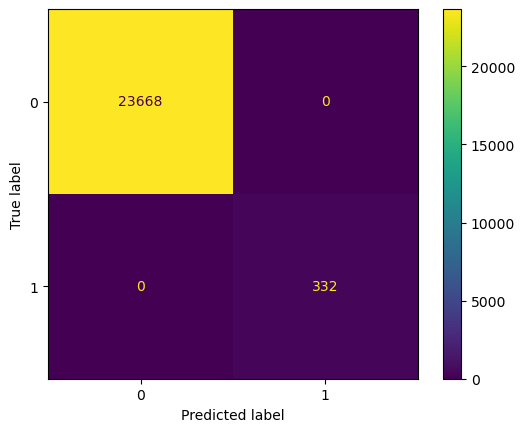

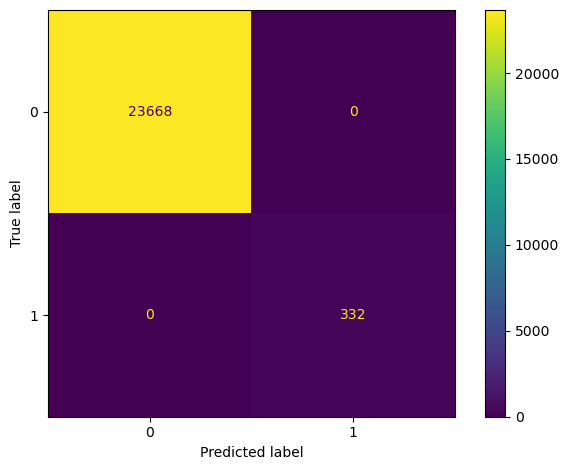

In [154]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(14, 12))

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Loop through each subplot
for i in range(15):
    ax = axes[i]
    ax.set_title(f"{list(dataset.MULTI_LABEL_Mapping.keys())[i]}")
    # Create a confusion matrix display
    display = ConfusionMatrixDisplay.from_predictions(y_trues[:, 1], y_trues[:, 1], xticks_rotation=90, cmap="Blues", ax=ax)
    display.plot()
    
    # Add labels or other customization as needed

# Adjust layout to prevent clipping of labels
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()